Nous allons tout d'abord installer (si necessaire) et charger les packages que l'on va utiliser dans le projet.

In [ ]:
# Installation du package geopandas
!pip install geopandas

     |████████████████████████████████| 972kB 5.9MB/s 
     |████████████████████████████████| 6.5MB 27.5MB/s 
     |████████████████████████████████| 14.8MB 324kB/s 


In [ ]:
# Chargement des packages 
import scipy as sp
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

Pour tester les différents algorithmes, nous allons créer et afficher un nuage de points E que l'on utilisera comme jeu de données par défaut dans cette première partie.

(2, 5)


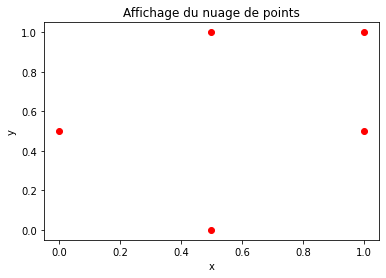

In [ ]:
N = 5
ord = 2
#E = np.random.rand(2,N)
E = np.array([[1, 0.5], [0.5, 0], [0,0.5], [0.5, 1], [1,1]]).T
plt.title('Affichage du nuage de points')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(E[0,:], E[1,:], c='r')
print(E.shape)

Définition des fonctions Jp, dJp et HJp :

In [ ]:
def my_Jp(x, E=E, ord=2):
    X = x.reshape(2,-1)
    return np.sum(np.linalg.norm(X-E, axis=0, ord=ord))

def my_grad_Jp(x, E=E, ord=2, eps=1e-18):
    X = x.reshape(2,-1)
    return (np.sum(np.sign(X-E) * np.abs(X-E)**(ord-1) * (np.linalg.norm(X-E, axis=0, ord=ord) + eps)**(1-ord), axis=1)).reshape(2,-1)

def my_Hess_Jp(x, E=E, ord=2, eps=1e-18):
    X = x.reshape(2,-1)
    L = (ord-1) * (np.linalg.norm(X - E, ord=ord) + eps)**(1-ord) * np.abs(X-E)**(ord-2) * (1 - (np.linalg.norm(X-E, ord=ord) + eps)**(-ord) * np.abs(X-E)**ord)
    dxdy_ = np.sign(X-E) * (np.abs(X-E) ** (ord-1))
    dxdy = dxdy_[0] * dxdy_[1] * (1-ord) * ((np.linalg.norm(X-E, ord=ord) + eps)** (1 - 2 * ord))
    return np.array([[np.sum(L[0]), np.sum(dxdy)], [np.sum(dxdy), np.sum(L[1])]])

Visualisation des courbes de niveaux :

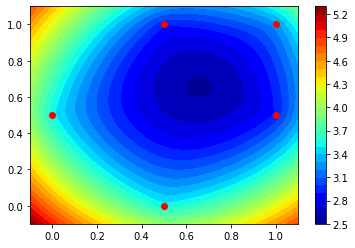

In [ ]:
n_grid = 101
x_ = np.linspace(-0.1, 1.1, n_grid)
y_ = np.linspace(-0.1, 1.1, n_grid)
X_mesh, Y_mesh = np.meshgrid(x_, y_)

Z = np.zeros_like(X_mesh)
for i in range(n_grid):
    for j in range(n_grid):
        Z[i,j] = my_Jp(np.array([[X_mesh[i,j]],[Y_mesh[i,j]]]))
plt.contourf(x_, y_, Z, 30, cmap='jet')
plt.colorbar()
plt.scatter(E[0], E[1], c='r')


# 1. Optimisation sans contraintes dans le plan 



4. Implémenter un algorithme de construction de l’enveloppe convexe pour les points (xi)i∈[1,n], on pourra penser à l’algorithme de Jarvis ou à en algorithme faisant intervenir un tri rapide (par exemple le parcours de Graham de complexité n log(n) pour des données de taille n).

In [ ]:
# Implémentation de l'algorithme de Jarvis permettant de construire l'enveloppe convexe de n points données : 

def point_abs_min(L):
    min = L[0]
    index = 0
    for i, p in enumerate(L[1:], 1):
        if p[0] < min[0]:
            min = p
            indice = i
        elif p[0] == min[0]:
            if p[1] < min[1]:
                min = p
                index = i
    return index


def orientation(a, b ,c):
    v_ab = (b[0] - a[0], b[1] - a[1])  
    v_ac = (c[0] - a[0], c[1] - a[1])  
    det = v_ab[0]*v_ac[1] - v_ab[1]*v_ac[0] 
    if det > 0:
        return 1
    if det < 0:
        return -1
    return 0


def prochain_sommet(L, i, debug=False):
    val = []
    for j in range(len(L)):
        if j == i:
            continue
        v = 0
        for k in range(len(L)):
            if k == i or k == j:
                continue
            v += orientation(L[i], L[j], L[k]) 
        val.append((j, v))
        if debug:
            print(val)
    val.sort(key=lambda x: x[1]) 
    if debug :
      print(val)
    return val[-1][0]


def Jarvis(L):
    i = point_abs_min(L)
    prochain = prochain_sommet(L, i)
    Enveloppe = [i, prochain]
    while prochain_sommet(L, prochain) != i:
        prochain = prochain_sommet(L, prochain)
        Enveloppe.append(prochain)
    return Enveloppe

def affiche_enveloppe(L, algorithme, xlim, ylim):
    Enveloppe = algorithme(L)

    X = [L[i][0] for i in Enveloppe]
    X.append(L[Enveloppe[0]][0])
    Y = [L[i][1] for i in Enveloppe]
    Y.append(L[Enveloppe[0]][1])

    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.plot(X, Y)

    labels = ['$x_{0}$'.format(i) for i in range(len(L))]
    for label, x, y in zip(labels, [p[0] for p in L], [p[1] for p in L]):
        plt.annotate(label, xy=(x, y),  va='bottom', ha='right', size='large', color='black')
    plt.grid(True)
    plt.scatter(L[:,0], L[:,1], c='r')
    plt.show()


Test de l'algorithme de Jarvis sur un nuage de points :

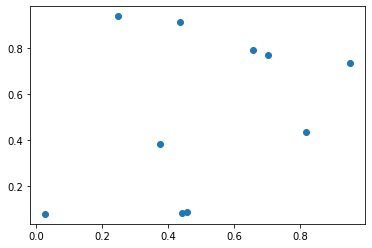

In [ ]:
nuage = np.random.rand(2, 10)
plt.scatter(nuage[0], nuage[1])

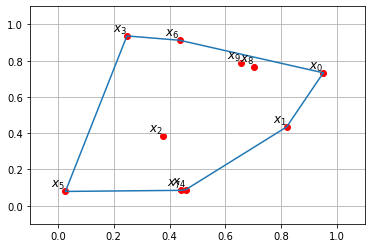

[[0.95088817 0.73325096]
 [0.43602354 0.9129339 ]
 [0.24704384 0.93682187]
 [0.02679259 0.07864944]
 [0.4415148  0.08463874]
 [0.4582139  0.08861296]
 [0.81948848 0.43458832]]


In [ ]:
Q = nuage.T
env_conv = np.array([Q[i] for i in Jarvis(Q)])
affiche_enveloppe(Q, Jarvis, xlim=(-0.1, 1.1), ylim=(-0.1, 1.1))
print(env_conv)

6. Implémenter les algorithmes de gradients à pas fixe, optimal et la généralisation du gradient conjugué. Indiquer, en justifiant votre choix, quelle approche vous semble la plus performante (en fonction de la précision, du temps de calcul, de la stabilité...)

Définition d'une fonction d'affichage

In [ ]:
def affichage_resultats(X0, X, it, trajectoire, valeurs_J, gradients_J, E):

    print('Départ :', X0.reshape(2,))
    print('Solution :', X.reshape(2,))
    print('Nombre d\'iterations :', it)
    print('Norme du gradient à la dernière itération :', gradients_J[-1], '\n')


    fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(10,5))
    #params = {'mathtext.default': 'regular' }   
    #plt.rcParams.update(params) 

    axs[0, 0].scatter(E[0], E[1], c='r')        # nuage de points en rouge
    axs[0, 0].scatter(X0[0], X0[1], c='g')      # point de départ en vert
    axs[0, 0].scatter(X[0], X[1], c='b')        # point d'arrivée en bleu
    axs[0, 0].set_title('Départ : point vert - Arrivée : point bleu')
    axs[0, 0].set_xlabel('x') 
    axs[0, 0].set_ylabel('y')

    axs[0, 1].scatter(E[0], E[1], c='r')
    axs[0, 1].scatter(trajectoire[0], trajectoire[1], c='b')
    axs[0, 1].set_title('Trajectoire des points Xk donnés par l\'algorithme')
    axs[0, 1].set_xlabel('x') 
    axs[0, 1].set_ylabel('y')

    axs[1, 0].plot(valeurs_J)
    axs[1, 0].set_title('Evolution de $J_{p}(X^{k})$')
    axs[1, 0].set_xlabel('k') 
    axs[1, 0].set_ylabel('$J_{p}(X^{k})$')

    axs[1, 1].plot(np.log(gradients_J))
    axs[1, 1].set_title('Evolution du gradient de $J_{p}(X^{k})$')
    axs[1, 1].set_xlabel('k') 
    axs[1, 1].set_ylabel('log(|| grad $J_{p}(X^{k})$ ||)')

    return axs

Test des algorithmes de descente :

In [ ]:
# Implémentation de différents algorithmes de descente :

# Descente de gradient à pas fixe : 

def desc_pf_Jp(X0, h=0.01, tol=1e-6, it_max=1000, E=E, ord=2):
    X = X0.reshape(2,-1)
    it = 0
    stop = False
    valeurs_J = []
    gradients_J = []
    trajectoire = [X]
    while not stop: 
        X = X - h * my_grad_Jp(X, E, ord)
        it += 1
        stop = (it >= it_max) or (np.linalg.norm(my_grad_Jp(X, E, ord)) <= tol)
        valeurs_J.append(my_Jp(X, E, ord))
        gradients_J.append(np.linalg.norm(my_grad_Jp(X, E, ord), ord=ord))
        trajectoire.append(X)
    trajectoire = (np.array(trajectoire).reshape(-1, 2)).T
    return X, it, trajectoire, valeurs_J, gradients_J

In [ ]:
# Descente de gradient à pas optimal : 

# Recherche du pas optimal à l'aide de la méthode de Newton
def recherche_pas_optimal_newton(Xk, Vk, h_, tol=1e-6, it_max=50, E=E, ord=2):
    X = Xk.reshape(2,-1)
    V = Vk.reshape(2,-1)

    list_h = []
    values = []
    grads = []

    h = h_
    it = 0
    stop = False
    while not stop: 
        H = my_Hess_Jp(X - h * V, E, ord)
        h = h + np.vdot(V, my_grad_Jp(X - h * V, E, ord)) / (np.vdot(V, np.dot(H, V))) / 10
        it +=1
        list_h.append(h)
        values.append(my_Jp(X - h * V, E, ord))
        grads.append(np.vdot(V, my_grad_Jp(X - h * V, E, ord)))
        stop = (np.abs(np.vdot(V, my_grad_Jp(X - h * V, E, ord))) <= tol) or (it >= it_max)
    return h, it, list_h, values, grads

# Recherche du pas optimal par dichotomie
def recherche_pas_optimal_dichotomie(Xk, Vk, tol=1e-6, it_max=100, E=E, ord=2):
    X = Xk.reshape(2,-1)
    V = Vk.reshape(2,-1)

    list_h = []
    values = []
    grads = []

    it = 0
    a = 0
    b = 10
    if -np.vdot(V, my_grad_Jp(X - b * V, E, ord)) < 0:
        stop_cherche_b = False
        while not stop_cherche_b:
            b = np.random.rand() * 10 ** (np.random.randint(-3,5))
            stop_cherche_b = (-np.vdot(V, my_grad_Jp(X - b * V, E, ord)) > 0)

    h = (a+b)/2
    val = -np.vdot(V, my_grad_Jp(X - h * V, E, ord))

    stop = False
    while not stop: 
        if val < 0:
            a = h
        else:
            b = h
        h = (a+b) / 2
        val = -np.vdot(V, my_grad_Jp(X - h * V, E, ord))
        it +=1
        list_h.append(h)
        values.append(my_Jp(X - h * V, E, ord))
        grads.append(np.vdot(V, my_grad_Jp(X - h * V, E, ord)))
        stop = (np.abs(val) <= tol) or (it >= it_max)
    return h, it, list_h, values, grads


# Descente de gradient à pas optimal
def desc_po_Jp(X0, methode_recherche_pas_optimal='dichotomie', tol=1e-6, it_max=1000, E=E, ord=2) :
    X = X0.reshape(2,-1)
    it = 0
    stop = False
    valeurs_J = []
    gradients_J = []
    trajectoire = [X]
    h = 200
    steps = []
    while not stop: 
        grad_X = my_grad_Jp(X,E,ord)
        if methode_recherche_pas_optimal == 'newton':
            h, _, _, _, _ = recherche_pas_optimal_newton(X, grad_X, h, E=E, ord=ord)
        if methode_recherche_pas_optimal == 'dichotomie':
            h, _, _, _, _ = recherche_pas_optimal_dichotomie(X, grad_X, E=E, ord=ord)
        X = X - h * grad_X
        norm_grad_ = np.linalg.norm(my_grad_Jp(X,E,ord))
        it += 1
        stop = (it >= it_max) or (norm_grad_ <= tol)
        valeurs_J.append(my_Jp(X, E, ord))
        gradients_J.append(norm_grad_)
        trajectoire.append(X)
        steps.append(h)
    trajectoire = (np.array(trajectoire).reshape(-1, 2)).T
    return X, it, trajectoire, valeurs_J, gradients_J, steps

In [ ]:
# Algorithme du gradient conjugué : 
def grad_conj_Jp(X0, methode_recherche_pas_optimal='dichotomie', tol=1e-6, it_max=1000, E=E, ord=2) :
    X = X0.reshape(2,-1)
    it = 0
    stop = False
    valeurs_J = []
    gradients_J = []
    trajectoire = [X]
    steps = []
    d = np.zeros_like(X)
    h = 200

    while not stop: 
        grad_X = my_grad_Jp(X,E,ord)
        hess_X = my_Hess_Jp(X,E,ord)
        d = grad_X - np.vdot(grad_X, hess_X.dot(d)) / (np.vdot(d, hess_X.dot(d)) + 1e-9) * d
        if methode_recherche_pas_optimal == 'newton':
            h, _, _, _, _ = recherche_pas_optimal_newton(X, d, h, E=E, ord=ord)
        if methode_recherche_pas_optimal == 'dichotomie':
            h, _, _, _, _ = recherche_pas_optimal_dichotomie(X, d, E=E, ord=ord)
        X = X - h * d
        norm_grad_ = np.linalg.norm(my_grad_Jp(X,E,ord))
        it += 1
        stop = (it >= it_max) or (norm_grad_ <= tol)
        valeurs_J.append(my_Jp(X, E, ord))
        gradients_J.append(norm_grad_)
        trajectoire.append(X)
        steps.append(h)
    trajectoire = (np.array(trajectoire).reshape(-1, 2)).T
    return X, it, trajectoire, valeurs_J, gradients_J, steps

On privilégiera la descente de gradient à pas optimal.

7. Implémenter aussi une méthode d’ordre 2, de type Newton. Comparez-là aux approches précédentes.

In [ ]:
## Implémentation d'une méthode d'ordre 2 de Newton :

def my_Newton_Jp(X0, tol=1e-6, it_max=100, E=E, ord=2):
    X = X0.reshape(2,-1)
    it = 0
    stop = False
    valeurs_J = []
    gradients_J = []
    trajectoire = [X]
    while not stop: 
        X = X - np.linalg.solve(my_Hess_Jp(X, E, ord), my_grad_Jp(X, E, ord)) / 5   # H^-1 x grad vérifie H X = grad
#        X = X - np.dot(np.linalg.inv(my_Hess_Jp(X, E, ord)),  my_grad_Jp(X, E, ord))
        norm_grad_ = np.linalg.norm(my_grad_Jp(X,E,ord))
        it += 1
        stop = (it >= it_max) or (norm_grad_ <= tol)
        valeurs_J.append(my_Jp(X, E, ord))
        gradients_J.append(np.linalg.norm(my_grad_Jp(X, E, ord), ord=ord))
        trajectoire.append(X)
    trajectoire = (np.array(trajectoire).reshape(-1, 2)).T
    return X, it, trajectoire, valeurs_J, gradients_J

La méthode de Newton est très efficace, mais la convergence est beaucoup trop dépendante du choix du point de départ. Il suffit de prendre un nuage de points plus "compliqué" pour s'en convaincre.

# Projection et mise en oeuvre pratique

In [ ]:
# Chargement des données :

cities = pd.DataFrame(
    {'City': ['Alger', 'Antananarivo', 'Atlanta', 'Cape Town', 'Dakar', 'Irkoutsk', 'Le Caire', 'Libreville', 'Moscou', 'Nairobi', 'New Delhi',
              'Paris', 'Pékin', 'Quito', 'Rome', 'Seattle', 'Sydney', 'Stockholm', 'Tokyo'],
     'Longitude': [3.060188, 47.525581, -84.390264, 18.417396, -17.447938, 104.280586, 31.2357257, 9.454001, 37.6174943, 36.8172449, 77.2090057,
                   2.3514616, 116.718583, -78.5123274, 12.4829321, -122.3300624, 151.2164539, 18.0710935, 139.7594549],
     'Latitude': [36.775361, -18.910012, 33.748992, -33.928992, 14.693425, 52.289597, 30.0443879, 0.390002, 55.7504461, -1.2832533, 28.6138954,
                  48.8566969, 39.9020668, -0.2201641, 41.8933203, 47.6038321, -33.8548157, 59.3251172, 35.6828387]})

gpd_cities = geopandas.GeoDataFrame(cities, geometry=geopandas.points_from_xy(cities.Longitude, cities.Latitude))
#gpd_cities = gpd_cities.set_crs("EPSG:3857")
gpd_cities = gpd_cities.set_crs("EPSG:4326")
print(gpd_cities)


# On stocke les coordonnées des villes dans un tableau numpy

if 0:
    Xmin, Xmax = -1, 1
    Ymin, Ymax = - 0.5, 0.5
    villes = np.array([gpd_cities['Longitude'], gpd_cities['Latitude']]) / 180
else:
    Xmin, Xmax = -180, 180
    Ymin, Ymax = - 90, 90
    villes = np.array([gpd_cities['Longitude'], gpd_cities['Latitude']])

print('\n', villes)
print(villes.shape)
N_villes = len(villes[0])
print(N_villes)

            City   Longitude   Latitude                     geometry
0          Alger    3.060188  36.775361     POINT (3.06019 36.77536)
1   Antananarivo   47.525581 -18.910012   POINT (47.52558 -18.91001)
2        Atlanta  -84.390264  33.748992   POINT (-84.39026 33.74899)
3      Cape Town   18.417396 -33.928992   POINT (18.41740 -33.92899)
4          Dakar  -17.447938  14.693425   POINT (-17.44794 14.69342)
5       Irkoutsk  104.280586  52.289597   POINT (104.28059 52.28960)
6       Le Caire   31.235726  30.044388    POINT (31.23573 30.04439)
7     Libreville    9.454001   0.390002      POINT (9.45400 0.39000)
8         Moscou   37.617494  55.750446    POINT (37.61749 55.75045)
9        Nairobi   36.817245  -1.283253    POINT (36.81724 -1.28325)
10     New Delhi   77.209006  28.613895    POINT (77.20901 28.61390)
11         Paris    2.351462  48.856697     POINT (2.35146 48.85670)
12         Pékin  116.718583  39.902067   POINT (116.71858 39.90207)
13         Quito  -78.512327  -0.2

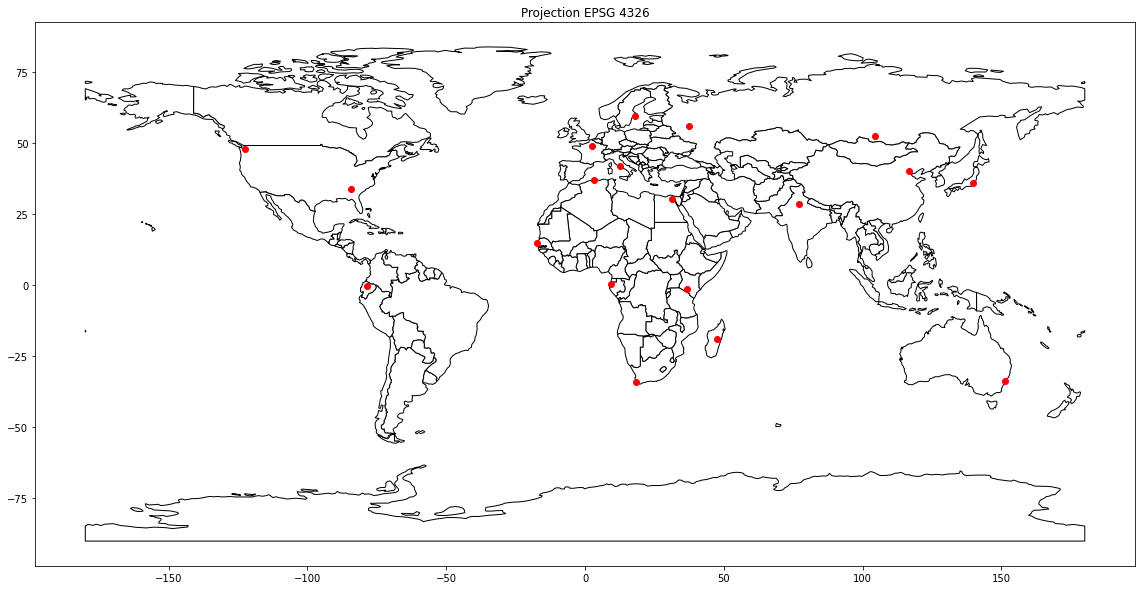

In [ ]:
# Affichage des villes :


#fig, ax = plt.subplots(figsize=(10, 5))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(20, 10))
gpd_cities.plot(ax=ax, color='red')
ax.set_title('Projection EPSG 4326')
plt.show()

Visualisation des courbes de niveaux :

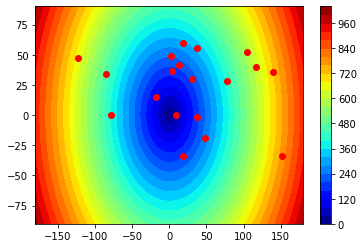

In [ ]:
n_grid = 101
x_ = np.linspace(Xmin - 0.1, Xmax + 0.1, n_grid)
y_ = np.linspace(Ymin - 0.1, Ymax + 0.1, n_grid)
X_mesh, Y_mesh = np.meshgrid(x_, y_)

Z = np.zeros_like(X_mesh)
for i in range(n_grid):
    for j in range(n_grid):
        Z[i,j] = my_Jp(np.array([[X_mesh[i,j]],[Y_mesh[i,j]]]))
plt.contourf(x_, y_, Z, 30, cmap='jet')
plt.colorbar()
plt.scatter(villes[0], villes[1], c='r')

1. Se ramener à une optimisation dans le plan à l’aide du système de projection choisi.

Départ : [-122.3300624   47.6038321]
Solution : [24.81036023 27.934105  ]
Nombre d'iterations : 19
Norme du gradient à la dernière itération : 5.182949713477032e-10 



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f578737f358>,
      dtype=object)

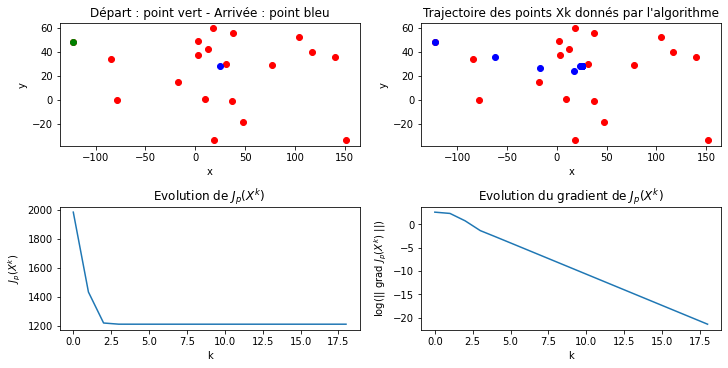

In [ ]:
 # Descente de gradient à pas fixe :

#X0 = np.sum(villes, axis=1)/N_villes
#X0 = np.array([0,1])
X0 = villes[:,15]

X, it, trajectoire, valeurs_J, gradients_J = desc_pf_Jp(X0, h=3.5, it_max=5000, tol=1e-9, E=villes, ord=2)
affichage_resultats(X0, X, it, trajectoire, valeurs_J, gradients_J, villes)

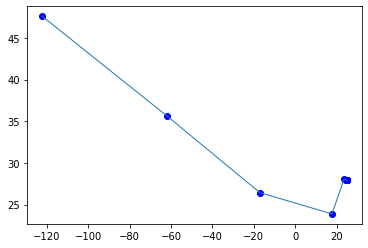

In [ ]:
# zoom sur la trajectoire

plt.scatter(trajectoire[0], trajectoire[1], c='b')
plt.plot(trajectoire[0], trajectoire[1], linewidth=1)

Départ : [-122.3300624   47.6038321]
Solution : [24.81036023 27.93410499]
Nombre d'iterations : 13
Norme du gradient à la dernière itération : 5.103633845437462e-10 



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f578812ccc0>,
      dtype=object)

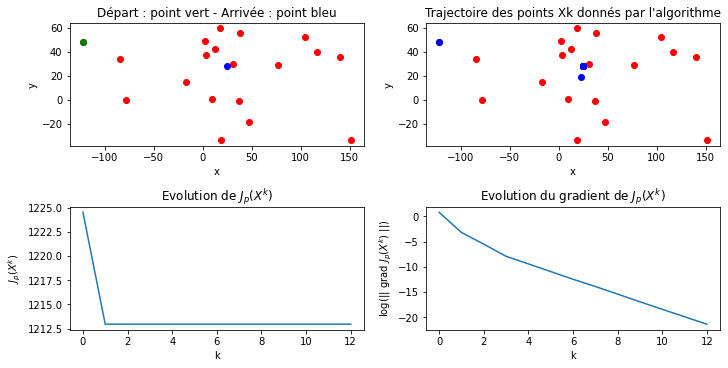

In [ ]:
# Descente de gradient à pas optimal : 

#X0 = np.sum(villes, axis=1)/N_villes
#X0 = np.array([0,1])
X0 = villes[:,15]

X, it, trajectoire, valeurs_J, gradients_J, steps = desc_po_Jp(X0, methode_recherche_pas_optimal='newton', tol=1e-9, it_max=5000, E=villes, ord=2)
affichage_resultats(X0, X, it, trajectoire, valeurs_J, gradients_J, villes)

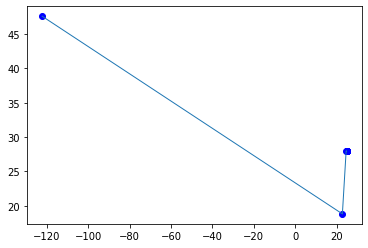

In [ ]:
# zoom sur la trajectoire

plt.scatter(trajectoire[0], trajectoire[1], c='b')
plt.plot(trajectoire[0], trajectoire[1], linewidth=1)

Départ : [-122.3300624   47.6038321]
Solution : [24.81036023 27.934105  ]
Nombre d'iterations : 13
Norme du gradient à la dernière itération : 2.6029935440922046e-10 



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5787e78668>,
      dtype=object)

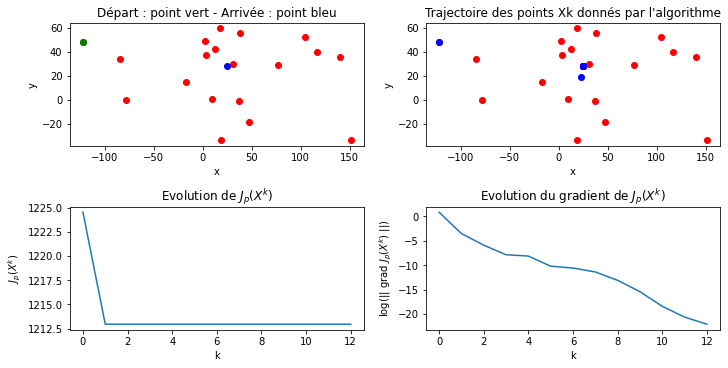

In [ ]:
# Descente de gradient conjugué : 

#X0 = np.sum(villes, axis=1)/N_villes
#X0 = np.array([0,1])
X0 = villes[:,15]

X, it, trajectoire, valeurs_J, gradients_J, steps = grad_conj_Jp(X0, methode_recherche_pas_optimal='newton', tol=1e-9, it_max=5000, E=villes, ord=2)
affichage_resultats(X0, X, it, trajectoire, valeurs_J, gradients_J, villes)

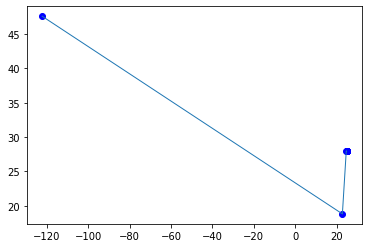

In [ ]:
# zoom sur la trajectoire

plt.scatter(trajectoire[0], trajectoire[1], c='b')
plt.plot(trajectoire[0], trajectoire[1], linewidth=1)

Départ : [-122.3300624   47.6038321]
Solution : [24.81036023 27.934105  ]
Nombre d'iterations : 18
Norme du gradient à la dernière itération : 3.1077750867682727e-10 



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5787cd5908>,
      dtype=object)

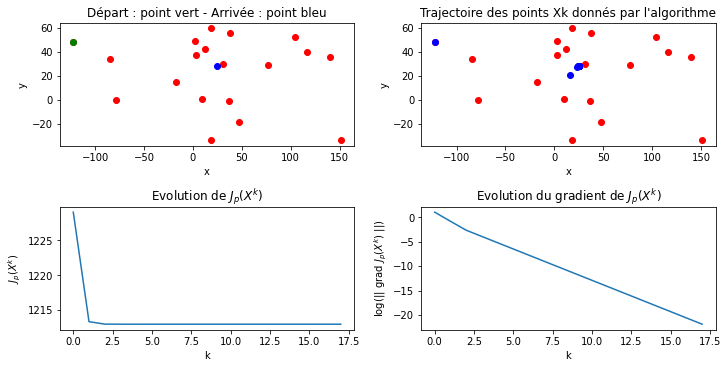

In [ ]:
# Test méthode de newton 2 : 

#X0 = np.sum(villes, axis=1)/N_villes
X0 = villes[:,15]

X, it, trajectoire, valeurs_J, gradients_J = my_Newton_Jp(X0, tol=1e-9, it_max=500, E=villes, ord=ord)
affichage_resultats(X0, X, it, trajectoire, valeurs_J, gradients_J, villes)

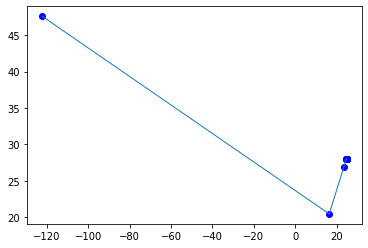

In [ ]:
# zoom sur la trajectoire

plt.scatter(trajectoire[0], trajectoire[1], c='b')
plt.plot(trajectoire[0], trajectoire[1], linewidth=1)

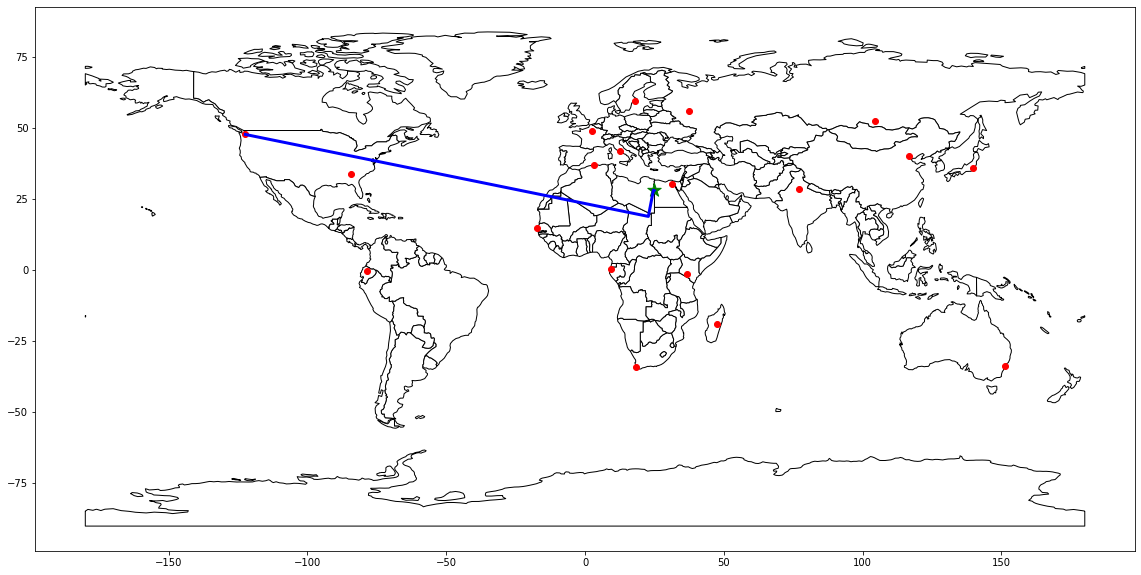

In [ ]:

X, it, trajectoire, valeurs_J, gradients_J, steps = desc_po_Jp(X0, methode_recherche_pas_optimal='newton', tol=1e-9, it_max=5000, E=villes, ord=2)
X_opti_dg_po = X
trajectoire_opti_dg_po = trajectoire

ax = world.plot(color='white', edgecolor='black', figsize=(20,10))
gpd_cities.plot(ax=ax, color='red')
plt.scatter(X_opti_dg_po[0], X_opti_dg_po[1], c='g', marker='*', s=200)
#plt.scatter(trajectoire_opti_dg_po[0], trajectoire_opti_dg_po[1], c='b')
plt.plot(trajectoire_opti_dg_po[0], trajectoire_opti_dg_po[1], c='b', linewidth=3)

plt.show()

On est parti de Seattle et on arrive à l'optimum situé à la frontière de la Lybie et l'Egypte (point désigné par une étoile verte). On remarque que les premières directions de descente sont bien orthogonales. Les suivantes sont trop petites pour être visibles.

2. Modifier le problème d’optimisation précédent de sorte à tenir compte de la déformation des géodésiques de la sphère par la projection.

Pour tenir compte de la déformation des géodésiques, il ne faut plus calculer la distance associée à la norme p entre deux points A et B du plan mais calculer la trajectoire sur la sphère entre A et B :

In [ ]:
def dist_sphere(x, y, rayon=6400):  # rayon en km, A: point, B: point ou nuage de points écrits en colonnes
# x, y : longitudes et latitudes des points x et y en degrés
# A, B : longitudes et latitudes des points x et y en radians
    A = x.reshape(2,1) * np.pi / 180
    B = y.reshape(2,-1) * np.pi / 180
    res = np.arccos(np.sin(A[1]) * np.sin(B[1]) + np.cos(A[1]) * np.cos(B[1]) * np.cos(B[0] - A[0]))
    return np.sum(res) * rayon

# on vérifie que la distance entre deux points opposés de la sphère de rayon 1 vaut pi
print(dist_sphere(np.array([90, 0]), np.array([-90, 0]), rayon=1))

3.141592653589793


Il faudrait alors définir une nouvelle fonction de coût ainsi que ses dérivées : 

In [ ]:
# Définition de la fonction de coût à l'aide des géodésiques de la sphère
def J_sphere(x, E=E, rayon=1):
    return dist_sphere(x, E, rayon=rayon)

def grad_J_sphere(x, E=E, rayon=6400):
    return 0

def Hess_J_sphere(x, E=E, rayon=6400):
    return 0

3. Les optimaux obtenus sont-ils très différents suivant ces deux méthodes ?

Les optimaux obtenus suivant ces deux méthodes peuvent être très différents. Par exemple, si on cherche le point qui minimise la somme des distances à Tokyo, Seattle et Quito sur la sphère, on obtient un point à l'intérieur du triangle formé par ces trois villes, au milieu du Pacifique. Si on cherche le point qui minimise les distances à ces villes sur le plan, on obtiendrait un point situé approximativement en Europe ou en Afrique du Nord !

# Cas contraint

1. La première chose à effectuer est une forme de vérification. L’idée est de considérer dans le cadre de la Section 1 précédente (optimisation dans le plan) un domaine de contraintes qui contient en fait l’optimum sans contraintes. Dans ce cadre on va mettre en oeuvre un algorithme contraint et l’on doit bien sûr retomber sur l’optimum précédent. On pourra choisir des domaines faisant intervenir des contraintes  égalité et/ou inégalités et tels que les points soient qualifiés en un sens vu en cours (condition de Karush, Kuhn et Tucker ou Slater).

**Implémentation de l'algorithme d'Arrow Hurwicz.**

On choisit pour espace des contraintes un rectangle contenant l'ensemble des villes

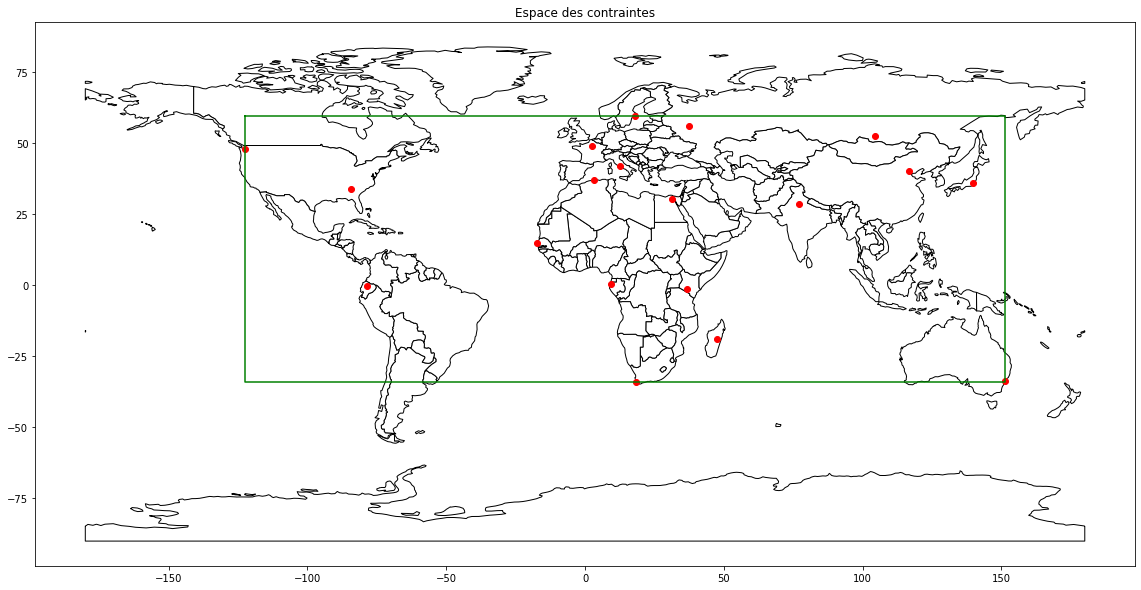

In [ ]:
xmin, xmax = np.min(villes[0]), np.max(villes[0])
ymin, ymax = np.min(villes[1]), np.max(villes[1])

ax = world.plot(color='white', edgecolor='black', figsize=(20,10))
gpd_cities.plot(ax=ax, color='red')
ax.set_title('Espace des contraintes')

plt.plot([xmin, xmax, xmax, xmin, xmin], [ymax, ymax, ymin, ymin, ymax], c='g')
plt.show()


Algorithme d'Arrow Hurwicz :

Départ : [151.2164539 -33.928992 ]
Solution : [24.81036494 27.93410495]
Nombre d'iterations : 1598
Norme du gradient à la dernière itération : 9.911057838731184e-07 



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f57875ffa90>,
      dtype=object)

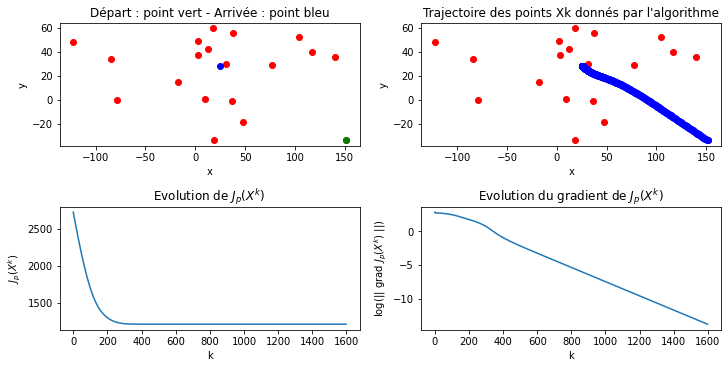

In [ ]:
X0 = np.array([xmax, ymin])
Y0 = np.zeros((4,1))
sigma, rho = 0.05, 0.05
tol = 1e-6

stop = False
X = X0.reshape(2,-1)
Y = Y0.reshape(4,-1)
it = 0
itmax = 5000
trajectoire = [X]
valeurs_J = [my_Jp(X, villes)]
gradients_J = [np.linalg.norm(my_grad_Jp(X, villes))]

while not stop:
  X = X - sigma * (my_grad_Jp(X, villes) + np.array([[-Y[0,0] + Y[1,0]], [-Y[2,0] + Y[3,0]]])) #np.array([[-1, 1, 0, 0], [0, 0, -1, 1]]).dot(Y)
  Y = Y + rho * np.array([[-X[0,0] + xmin], [X[0,0] - xmax], [-X[1,0] + ymin], [X[1,0] - ymax]])
  Y = Y * (Y > 0)

  val = my_Jp(X, villes)
  grad = my_grad_Jp(X, villes)
  norm_grad = np.linalg.norm(grad)

  it += 1
  stop = (norm_grad < tol) or (it >= itmax)

  trajectoire.append(X)
  valeurs_J.append(val)
  gradients_J.append(norm_grad)

trajectoire = (np.array(trajectoire).reshape(-1, 2)).T

X_opti_arrow_hurwicz = X
trajectoire_opti_arrow_hurwicz = trajectoire

affichage_resultats(X0, X, it, trajectoire, valeurs_J, gradients_J, villes)

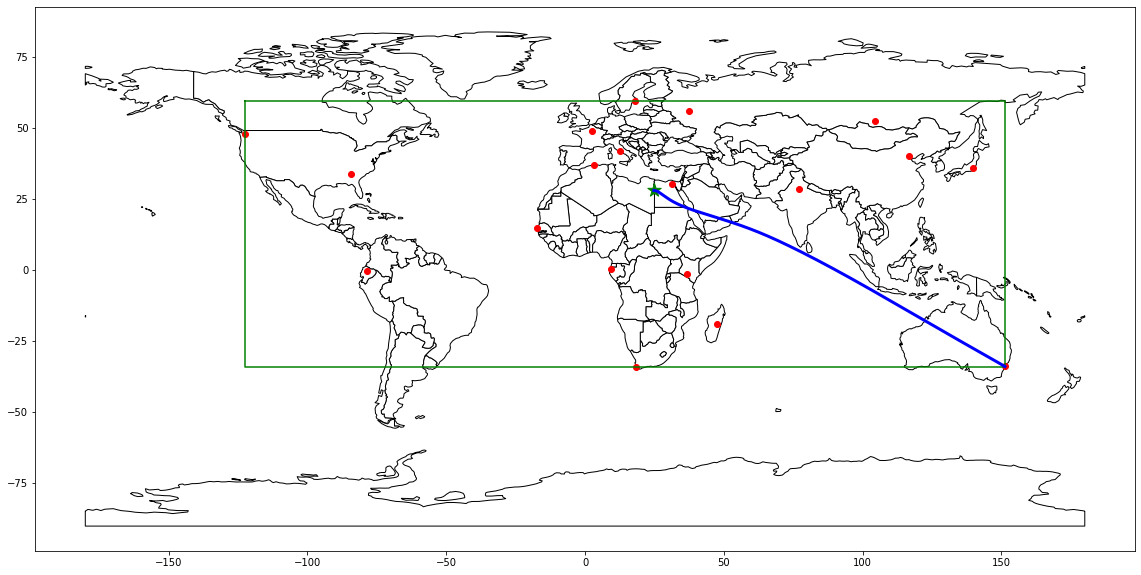

In [ ]:
ax = world.plot(color='white', edgecolor='black', figsize=(20,10))
gpd_cities.plot(ax=ax, color='red')

plt.plot([xmin, xmax, xmax, xmin, xmin], [ymax, ymax, ymin, ymin, ymax], c='g')
plt.scatter(X_opti_arrow_hurwicz[0], X_opti_arrow_hurwicz[1], c='g', marker='*', s=200)
plt.plot(trajectoire_opti_arrow_hurwicz[0], trajectoire_opti_arrow_hurwicz[1], c='b', linewidth=3)

plt.show()


2. Toujours dans le cadre de l’optimisation planaire, considérer des ensembles adéquats (au sens qu’ils vérifieront les conditions de qualification) mais qui ne contiennent plus le point optimal non contraint. Etudier l’influence du choix du domaine contraint sur l’optimum associé.

Cf question 3. En effet, les boules données dans la question 3 sont des exemples d'ensembles qui ne contiennent pas l'optimum et chacune d'entre elles vérifie les conditions de qualification de KKT car elle est définie par une seule contrainte dont le gradient n'est jamais nul quand la contrainte est saturée.

3. Dans le cadre du problème concret essayer de chercher, un optimum en considérant une boule de rayon 1000 km autour de Moscou, un rayon de 1500 km autour de Lincoln Nebraska (USA). Une boule de 1500 km autour de Kisangani (République Démocratique du Congo). Une boule de 1500 Km autour de Cuiaba (Brésil).

In [ ]:
def arrow_hurwicz_2(X0, Y0, r, Z0, sigma=0.05, rho=0.05, tol=1e-6, it_max=1000, villes=villes, ord=2):

  stop = False
  X = X0.reshape(2,-1)
  Z = Z0.reshape(2,-1)
  Y = Y0
  it = 0

  trajectoire = [X]
  valeurs_J = [my_Jp(X, villes)]
  gradients_J = [np.linalg.norm(my_grad_Jp(X, villes))]

  while not stop:
    X = X - sigma * (my_grad_Jp(X, villes) + 2 * (X - Z)) 
    Y = Y + rho * (np.linalg.norm(X-Z)**2 - r**2)
    Y = Y * (Y > 0)

    val = my_Jp(X, villes)
    grad = my_grad_Jp(X, villes)
    norm_grad = np.linalg.norm(grad)

    it += 1
    stop = (norm_grad < tol) or (it >= itmax)

    trajectoire.append(X)
    valeurs_J.append(val)
    gradients_J.append(norm_grad)

  trajectoire = (np.array(trajectoire).reshape(-1, 2)).T

  return X, Y, it, trajectoire, valeurs_J, gradients_J

        City  Longitude   Latitude  Rayon                     geometry
0     Moscow  37.617298  55.755825   1000    POINT (37.61730 55.75583)
1    Lincoln -96.702599  40.813618   1500   POINT (-96.70260 40.81362)
2  Kisangani  25.188271   0.527510   1500     POINT (25.18827 0.52751)
3     Cuiaba -56.097893 -15.601411   1500  POINT (-56.09789 -15.60141)


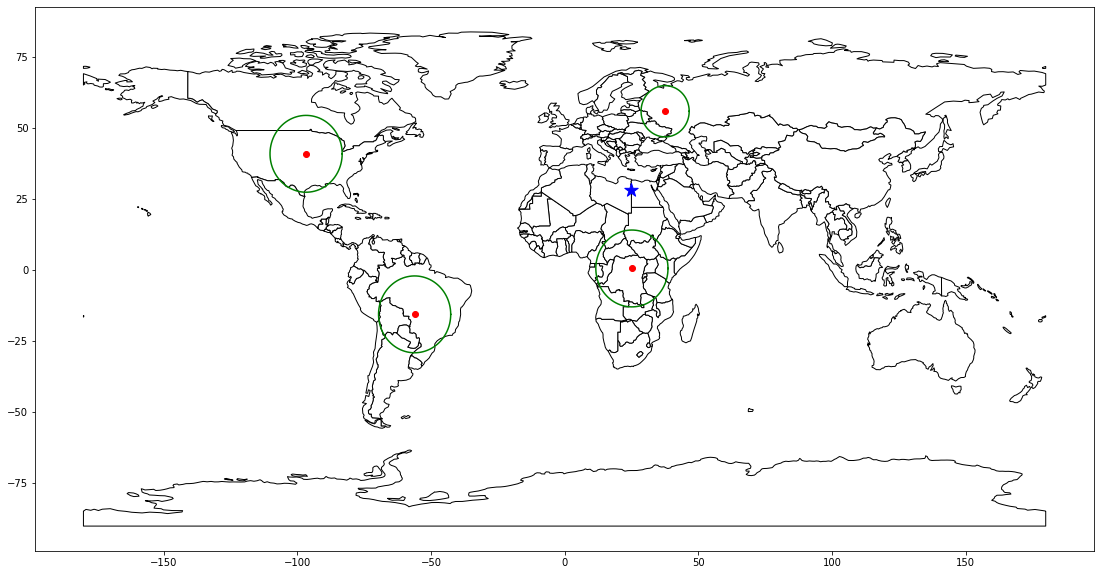

In [ ]:
cities_q3 = pd.DataFrame(
    {'City': ['Moscow', 'Lincoln', 'Kisangani', 'Cuiaba'],
     'Longitude': [37.617298, -96.702599, 25.188271, -56.097893],
     'Latitude': [55.755825, 40.813618, 0.527510, -15.601411],
     'Rayon': [1000, 1500, 1500, 1500]})

gpd_cities_q3 = geopandas.GeoDataFrame(cities_q3, geometry=geopandas.points_from_xy(cities_q3.Longitude, cities_q3.Latitude))
gpd_cities_q3 = gpd_cities_q3.set_crs("EPSG:4326")
print(gpd_cities_q3)

ax = world.plot(color='white', edgecolor='black', figsize=(20,10))
gpd_cities_q3.plot(ax=ax, color='red')

theta = np.linspace(0, 2*np.pi, 100)
x_ = np.cos(theta)
y_ = np.sin(theta)

for i in range(4):
    tmp = np.array(cities_q3.iloc[i][['Longitude', 'Latitude']]).reshape(2,-1) + 360 / 40000 * cities_q3.iloc[i]['Rayon'] * np.array([x_, y_])
    plt.plot(tmp[0], tmp[1], c='g')

plt.scatter(X_opti_arrow_hurwicz[0], X_opti_arrow_hurwicz[1], c='b', marker='*', s=200)

plt.show()



On voit bien sur la carte que l'optimum n'est dans aucune des quatre boules.

In [ ]:
X, Y, it, trajectoire, valeurs_J, gradients_J = {}, {}, {}, {}, {}, {}

for i in range(4):
    Z0 = np.array(cities_q3.iloc[i][['Longitude', 'Latitude']]).astype('float64').reshape(2,-1)
    r = 360 / 40000 * cities_q3.iloc[i]['Rayon']
    X0 = Z0     # on part à chaque fois de Moscou, Lincoln, Kisangani et Cuaiba
    Y0 = 0

    X[i], Y[i], it[i], trajectoire[i], valeurs_J[i], gradients_J[i] = arrow_hurwicz_2(X0, Y0, r, Z0, it_max=10000)


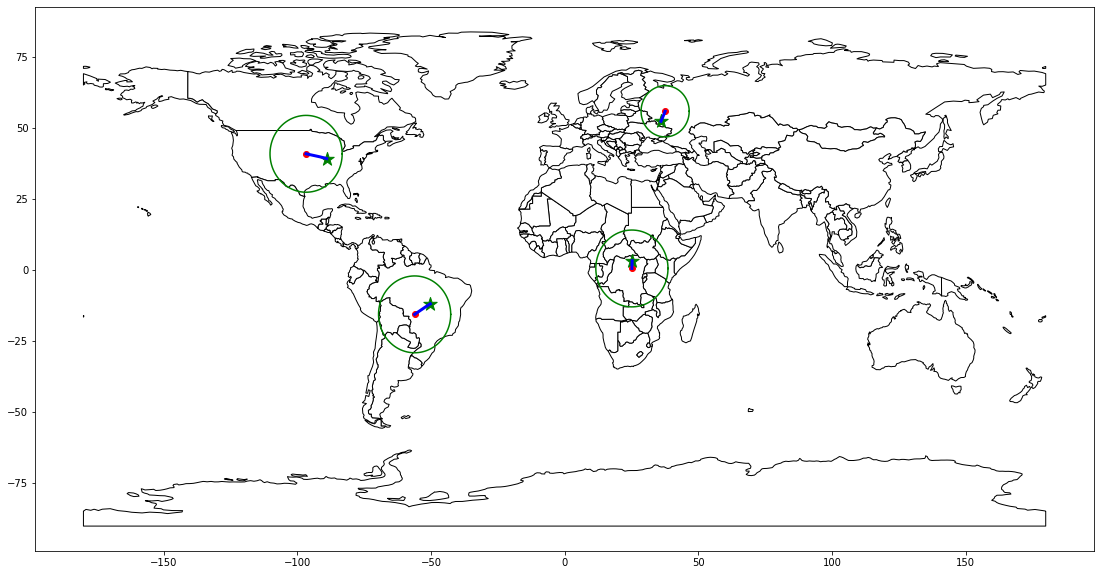

In [ ]:
ax = world.plot(color='white', edgecolor='black', figsize=(20,10))
gpd_cities_q3.plot(ax=ax, color='red')

theta = np.linspace(0, 2*np.pi, 100)
x_ = np.cos(theta)
y_ = np.sin(theta)

for i in range(4):
    tmp = np.array(cities_q3.iloc[i][['Longitude', 'Latitude']]).reshape(2,-1) + 360 / 40000 * cities_q3.iloc[i]['Rayon'] * np.array([x_, y_])
    plt.plot(tmp[0], tmp[1], c='g')
    plt.scatter(X[i][0], X[i][1], c='g', marker='*', s=200)
    plt.plot(trajectoire[i][0], trajectoire[i][1], c='b', linewidth=3)

plt.show()
